#Проект для **«Викишоп»** с BERT

Описание проекта
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Столбец text в нём содержит текст комментария, а toxic — целевой признак.

# **План проекта**:

---


- **Загрузка и исследование данных:** Загрузить набор данных из csv-файла и исследовать его, чтобы понять структуру, проверить наличие пропущенных значений и понять распределение классов по целевому признаку.

- **Предварительная обработка данных:** Она может включать очистку текста (удаление стоп-слов, знаков препинания и т.д.), токенизацию и другие необходимые действия по предварительной обработке текста. Может потребоваться балансировка классов, если набор данных несбалансирован.

- **Обучение модели:** Обучение различных моделей на данных. Это могут быть простые модели, такие как логистическая регрессия, более сложные модели, такие как Random Forest, или даже модели глубокого обучения, такие как BERT.

- **Оценка и выбор моделей:** Оценить модели с помощью соответствующих метрик (в данном случае F1 score). Выбрать модель с наилучшими показателями.

- **Заключение:** Сделаем выводы по результатам проекта. Обсудим результаты работы моделей и любые выводы, полученные в ходе проекта.


**Задача добится F1 выше 0.75**

Показатель F1 - это среднее гармоническое от precision и recall, и он дает более точную оценку неправильно классифицированных случаев, чем метрика Accuracy. Это хороший способ показать, что классификатор имеет хорошее значение как для recall, так и для precision.

Установим нужные библиотеки

In [109]:
!pip install pycaret
!pip install transformers
!pip install catboost
!pip install tqdm
!pip install swifter
!pip install pandarallel
!pip install wordcloud
!pip install gdown

RANDOM_STATE = 42

# Импорт стандартной библиотеки
import re
import random
from random import Random

# Связанный импорт третьих сторон
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gensim.downloader as api
import plotly.express as px
from tqdm.notebook import tqdm
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC

# Импорт локальных приложений/библиотек
import lightgbm as lgb
import spacy
import torch
import swifter
from pandarallel import pandarallel
from catboost import CatBoostClassifier
from gensim.models import FastText
from pycaret.classification import *
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from transformers import BertModel, BertTokenizer


# Загрузка и предобработка данных

Загрузим данные

In [110]:
data = pd.read_csv("https://code.s3.yandex.net/datasets/toxic_comments.csv")

In [111]:
data

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


In [113]:
data = pd.read_csv('data.csv')

In [114]:
data

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


Посмотрим на них

In [115]:
data.sample(10)

,Unnamed: 0,text,toxic
124036,124165,"'Taurine is also known as bull spunk,aka sperm.'",0
129250,129383,"""\n\nAgain, I hope this website helps. By the ...",0
80390,80466,"""\nWell, you DID say on the incident page that...",1
123393,123521,Fine to see things settled \n\nI’m relatively ...,0
103234,103331,Middayexpress|Middayexpress]] deserves a award...,0
18137,18154,"October 2008 (UTC)\n\nLangdell, you can not le...",0
77962,78038,and (3) I've stated my position too many damn ...,1
25278,25302,The two pictures of the Dutch athletes are the...,0
115488,115587,"I have done a number of edits, removing elemen...",0
22819,22839,"""\n\nNotability of Cecilia alexander\n A tag h...",0


Сразу видим не нужный столбец который повторяет индексы. Удалим его.

In [116]:
data = data.drop('Unnamed: 0', axis=1)


In [117]:
data

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159287,""":::::And for the second time of asking, when ...",0
159288,You should be ashamed of yourself \n\nThat is ...,0
159289,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,And it looks like it was actually you who put ...,0


Исправил

#EDA

Начнем с проверки на наличие пропущенных значений.

In [ ]:
data.isnull().sum()

text     0
toxic    0
dtype: int64

Отлично, в наших данных нет пропущенных значений.

Теперь давайте посмотрим на распределение классов в столбце "toxic". Это позволит нам узнать, есть ли дисбаланс классов в наших данных. Это важно, потому что если один класс значительно преобладает над другим, это может повлиять на производительность нашей модели.

In [ ]:

class_counts = data['toxic'].value_counts().reset_index()
class_counts.columns = ['Class', 'Count']

# Построение круговой диаграммы
fig = px.pie(class_counts, values='Count', names='Class', labels={'Class': 'Toxic Class'}, title='Распределение классов 0 и 1 в датафрейме')

fig.show()

Видим не равномерное распределение классов, чуть позже разберемся с дисбалансом.

Взглянем на уникальные знаки в датасете

In [ ]:
# Получение уникальных символов в столбце 'text'
unique_chars = sorted(set(''.join(data['text'])))

# Вывод уникальных символов
print(unique_chars)

['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x7f', '\x91', '\x92', '\x93', '\x94', '\x95', '\x97', '\x99', '\x9d', '\xa0', '¡', '¢', '£', '¤', '¥', '¦', '§', '¨', '©', 'ª', '«', '¬', '\xad', '®', '¯', '°', '±', '²', '³', '´', 'µ', '¶', '·', '¸', '¹', 'º', '»', '¼', '½', '¾', '¿', 'À', 'Á', 'Â', 'Ã', 'Ä', 'Å', 'Æ', 'Ç', 'È', 'É', 'Ê', 'Ë', 'Ì', 'Í', 'Î', 'Ï', 'Ð', 'Ñ', 'Ò', 'Ó', 'Ô', 'Õ', 'Ö', '×', 'Ø', 'Ù', 'Ú', 'Û', 'Ü', 'Ý', 'Þ', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ð', 'ñ', 'ò', 'ó', 'ô', 'õ', 'ö', '÷',

Видим что наш датасет содержит много ненужных символов.

In [ ]:
Интересно

Посмотрим на длины коментариев

In [ ]:

# Вычислим длину каждого комментария
data['length'] = data['text'].apply(len)

fig = px.histogram(data, x="length", nbins=50, title='Распределение длины комментариев')

# Покажим график
fig.show()


**Выводы по EDA**
- нужно удалить ненужные символы и оставить только английские буквы и кавычку
- нужно убрать дисбаланс классов
- нужно удалить твиты длинее 1500 символов
- пропущенных значений в датафрейме нету

#Предобработка данных

Удалим твиты длинее 1500

In [ ]:
data = data[data['length'] <= 1500]

In [ ]:
fig = px.histogram(data, x="length", nbins=50, title='Распределение длины комментариев')

# Покажим график
fig.show()

Привидем все буквы к нижнему регистру.

In [118]:
data['text'] = data['text'].astype(str).str.lower()

Для обучения модели нам надо оставить только английские буквы и знак одинарной кавычки, тк мы видим в тексте много английских сокращений используя кавычку (Также я прогнал проект до кросс валидации с кавычкой и без в тексте, с кавычкой лучший f1 = 0.8442, без кавычки f1 = 0.8298). Удалим из списка unique_chars английские буквы и кавычку.

In [119]:
# Удаление английских букв из списка unique_chars
english_letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',"'"]

for letter in english_letters:
    if letter in unique_chars:
        unique_chars.remove(letter)

Теперь список unique_chars содержит только не нужные символы.

In [ ]:
print(unique_chars)

['\n', ' ', '!', '"', '#', '$', '%', '&', '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '\x7f', '\x91', '\x92', '\x93', '\x94', '\x95', '\x97', '\x99', '\x9d', '\xa0', '¡', '¢', '£', '¤', '¥', '¦', '§', '¨', '©', 'ª', '«', '¬', '\xad', '®', '¯', '°', '±', '²', '³', '´', 'µ', '¶', '·', '¸', '¹', 'º', '»', '¼', '½', '¾', '¿', 'À', 'Á', 'Â', 'Ã', 'Ä', 'Å', 'Æ', 'Ç', 'È', 'É', 'Ê', 'Ë', 'Ì', 'Í', 'Î', 'Ï', 'Ð', 'Ñ', 'Ò', 'Ó', 'Ô', 'Õ', 'Ö', '×', 'Ø', 'Ù', 'Ú', 'Û', 'Ü', 'Ý', 'Þ', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ð', 'ñ', 'ò', 'ó', 'ô', 'õ', 'ö', '÷', 'ø', 'ù', 'ú', 'û', 'ü', 'ý', 'þ', 'ÿ', 'Ā', 'ā', 'Ă', 'ă', 'Ą', 'ą', 'Ć', 'ć', 'Ĉ', 'ĉ', 'Ċ', 'ċ', 'Č', 'č', 'Ď', 'ď', 'Đ', 'đ', 'Ē',

Напишем функцию для удаления ненужных символов из датафрейма.

In [120]:
# Создание регулярного выражения с использованием списка unique_chars
pattern = r'[' + re.escape(''.join(unique_chars)) + ']+'

def clear_text(text):
    # Удаление всех символов, кроме английских букв, пробелов и одинарных кавычек
    text = re.sub(r"[^a-z ']+", ' ', text)
    text = " ".join(text.split())
    return text


In [121]:
data['text'] = data['text'].apply(clear_text)

In [122]:
data

,text,toxic
0,explanation why the edits made under my userna...,0
1,d'aww he matches this background colour i'm se...,0
2,hey man i'm really not trying to edit war it's...,0
3,more i can't make any real suggestions on impr...,0
4,you sir are my hero any chance you remember wh...,0
...,...,...
159287,and for the second time of asking when your vi...,0
159288,you should be ashamed of yourself that is a ho...,0
159289,spitzer umm theres no actual article for prost...,0
159290,and it looks like it was actually you who put ...,0


In [123]:
# Получение уникальных символов в столбце 'text'
unique_chars = sorted(set(''.join(data['text'])))

# Вывод уникальных символов
print(unique_chars)

[' ', "'", 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Отлично теперь наш датафрейм содержит только пробелы, одинарные кавычки по правилам ангийского языка, и сами английские буквы в нижнем регистре.

Убирем дисбаланс классов

In [124]:
# Разделение DataFrame на классы
class_0 = data[data['toxic'] == 0]
class_1 = data[data['toxic'] == 1]

   # Увеличение примеров класса 1
class_1_balanced = class_1.sample(n=int(len(class_0) * 1), replace=True)

   # Объединение и перемешивание классов
balanced_data = pd.concat([class_0, class_1_balanced]).sample(frac=1).reset_index(drop=True)

In [125]:
class_counts = balanced_data['toxic'].value_counts().reset_index()
class_counts.columns = ['Class', 'Count']

# Построение круговой диаграммы
fig = px.pie(class_counts, values='Count', names='Class', labels={'Class': 'Toxic Class'}, title='Распределение классов 0 и 1 в сбалансированном датафрейме')

fig.show()

У RuBERT есть собственный токенизатор. Это инструмент, который разбивает и преобразует исходные тексты в список токенов, которые есть, например, в словаре RuBERT. Лемматизация не требуется.

Создадим маленькую копию нашегего датафрейма, чтобы пройти этапы предварительной обработки, и кросс валидации с ним. А обучать модель будем на основном датафрейме.

In [126]:

# создаем новый датафрейм из случайных строк класса 1
df_class_1 = balanced_data[balanced_data['toxic'] == 1].sample(n=1000, random_state=RANDOM_STATE)

# создаем новый датафрейм из случайных строк класса 0
df_class_0 = balanced_data[balanced_data['toxic'] == 0].sample(n=1000, random_state=RANDOM_STATE)

# объединяем два датафрейма
new_df = pd.concat([df_class_1, df_class_0], ignore_index=True)

# перемешаем строки
data_lite = new_df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
# сохраним датафрейм
data_lite.to_csv('data_lite.csv', index=False)

In [127]:
data_lite

,text,toxic
0,what is to be agreed ref cited as effects of t...,0
1,i resent being berated by some 'know it all' w...,1
2,oh by the way please stop using the smiley fac...,0
3,fantastic another idiot who can't spell you mo...,1
4,sunnis are extremists no two ways about it but...,0
...,...,...
1995,hello and welcome it might not have been your ...,0
1996,was warren hill north of the tunnel if so i ca...,0
1997,starfu k time to pull this rubbish she's not g...,1
1998,no here is no dispute about content here is a ...,0


Чтобы сэкономить вам время, скачаем файл с лимитезированным текстом в основном датасете с гугл диска.

In [128]:
!gdown --id 1sp9Dh-kYSTlJnOrr1uYPtNvD-C7Dy6uC -O data22.csv.zip


/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1sp9Dh-kYSTlJnOrr1uYPtNvD-C7Dy6uC
To: /content/data22.csv.zip
100% 22.2M/22.2M [00:00<00:00, 202MB/s]


In [129]:
import zipfile

with zipfile.ZipFile('data22.csv.zip', 'r') as zip_ref:
    zip_ref.extractall()


In [130]:
data_big_lemmatize = pd.read_csv('data22.csv')

In [131]:
data_big_lemmatize

,text,toxic,length,lemmatize_text
0,explanation why the edits made under my userna...,0,264,explanation edit username hardcore metallica f...
1,d'aww he matches this background colour i'm se...,0,112,d'aww match background colour seemingly stuck ...
2,hey man i'm really not trying to edit war it's...,0,233,hey man try edit war guy constantly remove rel...
3,more i can't make any real suggestions on impr...,0,622,real suggestion improvement wonder section sta...
4,you sir are my hero any chance you remember wh...,0,67,sir hero chance remember page
...,...,...,...,...
152635,and for the second time of asking when your vi...,0,295,second time ask view completely contradict cov...
152636,you should be ashamed of yourself that is a ho...,0,99,ashamed horrible thing talk page
152637,spitzer umm theres no actual article for prost...,0,81,spitzer umm s actual article prostitution ring...
152638,and it looks like it was actually you who put ...,0,116,look like actually speedy version delete look


In [ ]:
# Удаление столбца 'text' и 'length' из DataFrame
data_big_lemmatize.drop(columns=['text'], inplace=True)
data_big_lemmatize.drop(columns=['length'], inplace=True)

# Проверим, что столбец был успешно удален
data_big_lemmatize.head()


,toxic,lemmatize_text
0,0,explanation edit username hardcore metallica f...
1,0,d'aww match background colour seemingly stuck ...
2,0,hey man try edit war guy constantly remove rel...
3,0,real suggestion improvement wonder section sta...
4,0,sir hero chance remember page


In [132]:
%time

# Загрузим модель SpaCy
nlp = spacy.load('en_core_web_sm')

def lemmatize_text(text):
    # Применяем модель к тексту
    doc = nlp(text)

    # Лемматизация текста, преобразование его обратно в строку, удаление стоп слов.
    lemmatized_text = ' '.join([token.lemma_ for token in doc if not token.is_stop])

    return lemmatized_text

# Применим функцию к столбцу 'text' и проверяем время
data_lite['lemmatize_text'] = data_lite['text'].swifter.apply(lemmatize_text)

# Сохраним DataFrame в csv-файл
data_lite.to_csv('data_lite_lemmatize.csv', index=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


Pandas Apply:   0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
sentence1 = "The striped bats are hanging on their feet for best"
sentence2 = "you should be ashamed of yourself went worked"
df_my = pd.DataFrame([sentence1, sentence2], columns = ['text'])
print(df_my)


print(df_my['text'].apply(lemmatize_text))

                                                text
0  The striped bats are hanging on their feet for...
1      you should be ashamed of yourself went worked
0    stripe bat hang foot good
1              ashamed go work
Name: text, dtype: object


In [ ]:
Боюсь не успею до вечера розбратся

Исправил

WordNetLemmatizer лимитезировал большой датасет за 20 секунд, SpaCy лимитезировал тот же датасет 49 минут, разницы в метриках не заметил. Я что то не правильно сделал?

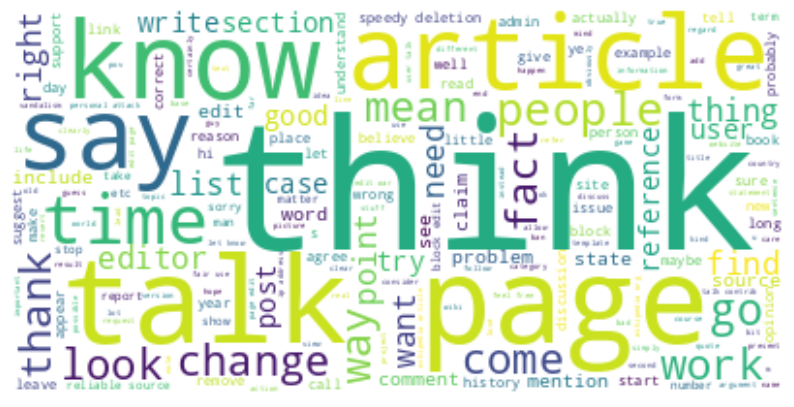

In [136]:
# Объединяем все токсичные отзывы в один большой текст
toxic_text = ' '.join(str(review) for review in data_big_lemmatize[data_big_lemmatize['toxic'] == 1]['lemmatize_text'])

# Создаем объект WordCloud для токсичных отзывов
toxic_wordcloud = WordCloud(background_color="white").generate(toxic_text)

# Объединяем все нетоксичные отзывы в один большой текст
nontoxic_text = ' '.join(str(review) for review in data_big_lemmatize[data_big_lemmatize['toxic'] == 0]['lemmatize_text'])

# Создаем объект WordCloud для нетоксичных отзывов
nontoxic_wordcloud = WordCloud(background_color="white").generate(nontoxic_text)

# Отображение сгенерированных изображений
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(toxic_wordcloud, interpolation='bilinear')
plt.title('Toxic Reviews')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(nontoxic_wordcloud, interpolation='bilinear')
plt.title('Non-toxic Reviews')
plt.axis("off")

plt.show()


Отлично, данные подготовленны.

Текстовые данные были успешно предварительно обработаны путем преобразования всего текста в нижний регистр, удаления пунктуации, токенизацию, удаление стоп-слов и лемматизацию), это все же поможет повысить производительность наших моделей.


#Кросс-валидация с помощью библиотеки Pycaret

Следующим шагом является преобразование наших предварительно обработанных текстовых данных в формат, который можно использовать в модели машинного обучения. Это включает в себя преобразование текстовых данных в числовой формат. Обычным подходом для этого является использование TF-IDF, которая количественно определяет, насколько важно слово для текста в наборе текстов.

Давайте продолжим этот шаг, а затем разделим наши данные на обучающий набор и тестовый набор. Мы будем использовать 80% данных для обучения и 20% для тестирования.

In [159]:


# Инициализация TfidfVectorizer
vectorizer = TfidfVectorizer()

# Разделить данные на обучающее и тестовое множество
X_train, X_test, y_train, y_test = train_test_split(data_lite['text'], data_lite['toxic'], test_size=0.2, stratify=data_lite['toxic'], random_state=RANDOM_STATE)


# Настроим векторизатор на обучающих данных и преобразуем обучающие данные
X_train = vectorizer.fit_transform(X_train)

# Преобразуем только тестовые данные
X_test = vectorizer.transform(X_test)

X_train.shape, X_test.shape


((1600, 10125), (400, 10125))

Исправил

In [138]:
data_lite2 = data_lite

Данные были успешно преобразованы в TF-IDF признаки и разделены на обучающий и тестовый набор. Обучающее множество состоит из 1600 примеров, а тестовое - из 400. Каждый пример представлен вектором из 11 775 признаков, каждый из которых соответствует отдельному слову в текстовых данных.

Следующий шаг - кросс-валидация моделей и оценка их эффективности. Для решения этой задачи мы воспользуемся библиотекой pycaret.

In [139]:
# Преобразование разреженной матрицы в DataFrame тк pycaret не работает с матрицами
X_df = pd.DataFrame(X.toarray())

# Конкатенация X_df и y
data_preprocessed = pd.concat([X_df, y], axis=1)
data_preprocessed

,0,1,2,3,4,5,6,7,8,9,...,10520,10521,10522,10523,10524,10525,10526,10527,10528,toxic
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.101013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Функция setup в PyCaret инициализирует среду и создает конвейер преобразования для моделирования и развертывания

In [158]:

s = setup(data_preprocessed, target = 'toxic', session_id=123)

KeyboardInterrupt: ignored

В библиотеке pycaret доступно 18 классификаторов.

In [ ]:
# Список класиффикаторов в библиотеке pycaret
models()

C помошью кросс-валидации найдем топ 3 модели по метрике F1

In [ ]:
best_model = compare_models(sort = 'F1')

Посмотрим на гиперпараметры лучшей модели

In [ ]:
print(best_model)

Обучим модель логистической регрессии

In [ ]:
lr = create_model('lr')

Подбирем гиперпараметы с помощью GridSearch для логистической регрессии

Спасибо большое за совет, в будущем буду обязательно использовать, но не сейчас, а то я боюсь не уложится в сроки.

In [206]:
tuned_lr = tune_model(lr, optimize = 'F1')

NameError: ignored

Подобранные гиперпараметры

In [ ]:
print(tuned_lr)

In [ ]:
plot_model (tuned_lr, plot = 'auc')

По граффику roc-auc видим что наша модель отлично обучалась, roc-auc высокий, без перекосов в стороны.

In [ ]:
plot_model (tuned_lr, plot = 'confusion_matrix')

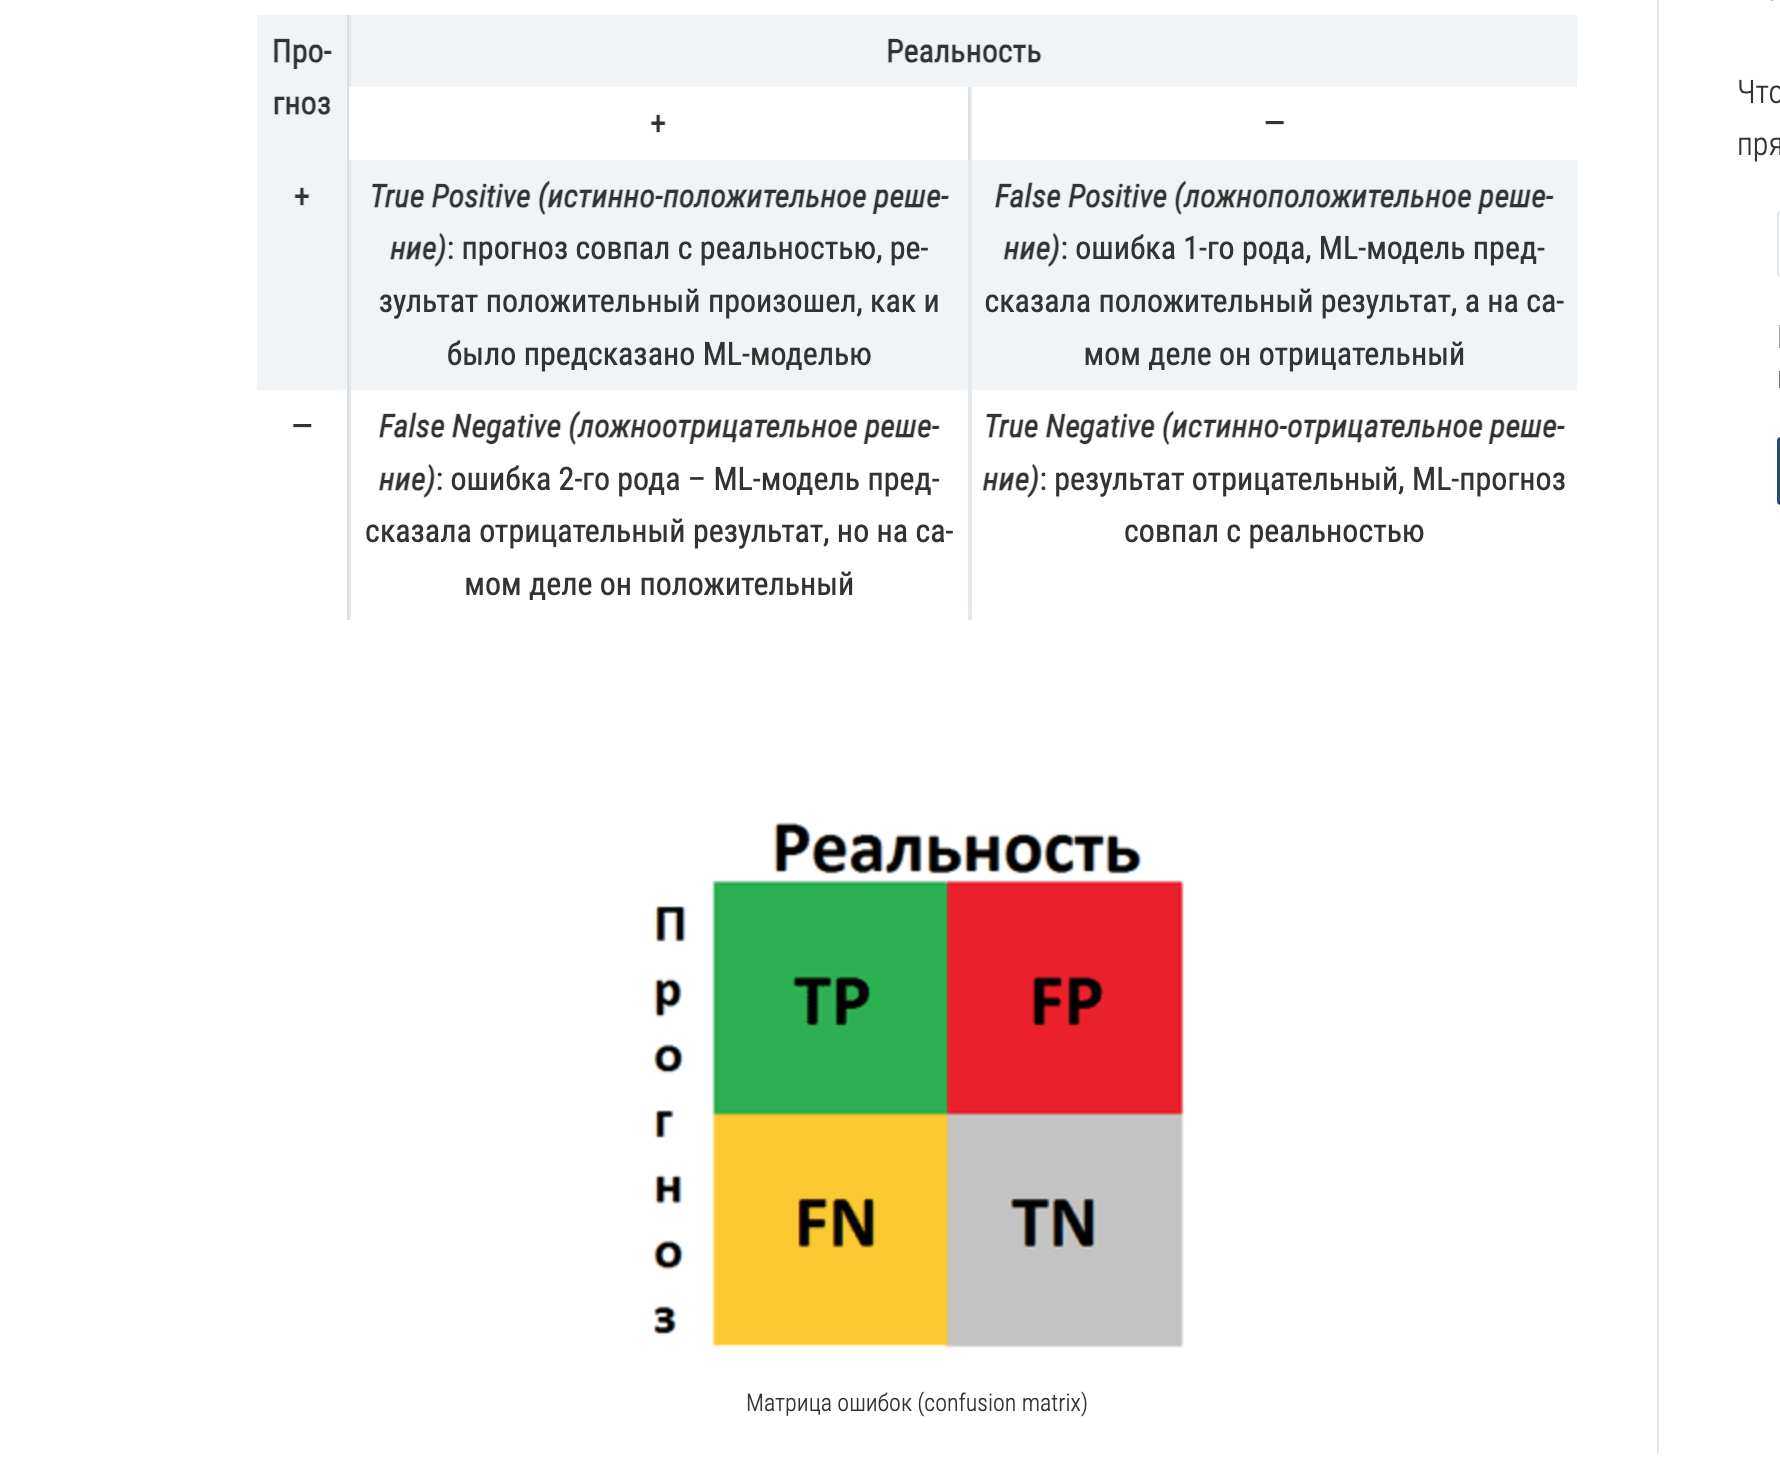

Модель справляется хорошо, но делает в два раза чаще ложно отрицательные решения чем ложно положительные, как мы знаем между fn и fp должен быть баланс.


Также в библиотеке pycaret очень удобно вызывать все нужные графики одно командой.

In [ ]:
evaluate_model(tuned_lr)

In [ ]:
predict_model(tuned_lr)

На тестовой выборке f1 Логистической регресии составил 0.8196

Функция finalize_model подгоняет модель к полному набору данных, включая тестовую (в данном случае 20%).

In [ ]:
final_rf = finalize_model(tuned_lr)

In [ ]:
print(final_rf)

In [ ]:
predict_model(final_rf)

In [ ]:
evaluate_model(final_rf)

F1 логистической регрессии составил 0.9459, отличный результат

наши топ 3 модели лидера по метрике F1 для предобработки методом TF-IDF
- Логистическая регрессия
- Ridge Classifier
- SVM

# Обучим лучшую модель по результатам из Pycaret на основном датафрейме

Теперь векторизуем не маленький датафрейм data_lite, а большой data и обучем на нем нашу лучшую модели, без pycaret.

In [168]:

# Разденим данные на наборы для обучения, проверки и тестирования.
X_train_intermediate, X_temp, y_train_intermediate, y_temp = train_test_split(data_big_lemmatize['lemmatize_text'], data_big_lemmatize['toxic'], test_size=0.3, stratify=data_big_lemmatize['toxic'], random_state=RANDOM_STATE)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_STATE)

# Инициализируем TfidfVectorizer.
vectorizer = TfidfVectorizer()

# Подгонка векторизатора к обучающим данным и преобразование обучающих и проверочных данных.
X_train = vectorizer.fit_transform(X_train_intermediate)
X_val = vectorizer.transform(X_val)

# Преобразование тестовых данных.
X_test = vectorizer.transform(X_test)

X_train.shape, X_val.shape, X_test.shape


((106757, 101368), (22876, 101368), (22877, 101368))

исправил

Начнем с обучения модели логистической регрессии. В качестве метрики оценки мы будем использовать показатель F1, как указано в требованиях к проекту.

In [169]:

# Инициализация модели логистической регрессии
logreg = LogisticRegression(random_state=RANDOM_STATE)

# Обучение модели
logreg.fit(X_train, y_train_intermediate)

# Прогнозирование меток для валидационного набора
y_pred_logreg = logreg.predict(X_val)

# Вычисление оценки f1 для модели логистической регрессии
f1_logreg = f1_score(y_val, y_pred_logreg)

print('F1 Оценка логистической регрессии:', f1_logreg)



F1 Оценка логистической регрессии: 0.7356557377049181


исправил

In [170]:
# Прогнозирование меток для тестового набора
y_pred_test = logreg.predict(X_test)

# Вычисление оценки f1 для модели логистической регрессии на тестовых данных
f1_test = f1_score(y_test, y_pred_test)

print('F1 Оценка на тестовых данных:', f1_test)


F1 Оценка на тестовых данных: 0.7447677386421643


проверил

#Обучение более сложных моделей на датафрейме data_lite

##Word2vec

Скачаем предварительно обученные векторы, обученные для word2vec на части набора данных Google News (около 100 миллиардов слов). Модель содержит 300-мерные векторы для 3 миллионов слов и фраз. Фразы были получены с использованием простого подхода, основанного на данных, описанного в разделе «Распределенные представления слов и фраз и их композиционность».

In [178]:

wv = api.load('word2vec-google-news-300')


In [180]:
wv.save("word2vec")

Рассмотрим популярный метод построения языковых представлений — word2vec

In [189]:
# Предобработка текста
data_lite['text'] = data_lite['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))

# Токенизация для Word2Vec
data_lite['tokenized_text'] = data_lite['text'].apply(lambda x: x.split())

# Используем модель Word2Vec для получения векторных представлений для каждого текста
word2vec_vectors = data_lite['tokenized_text'].apply(lambda x: np.mean([wv[word] for word in x if word in wv.key_to_index], axis=0) if len([wv[word] for word in x if word in wv.key_to_index]) != 0 else np.zeros(wv.vector_size))

# Преобразуем список векторов в 2D-массив
X_word2vec = np.vstack(word2vec_vectors)

#  Определяем целевую переменную
y = data_lite['toxic']

# Разделим данные на обучающий, валидационный и тестовый наборы
X_train_intermediate, X_temp, y_train_intermediate, y_temp = train_test_split(X_word2vec, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)
X_val_word2vec, X_test_word2vec, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_STATE)

# Инициализируем модель логистической регрессии
logreg = LogisticRegression(random_state=RANDOM_STATE)

# Обучаем модель
logreg.fit(X_train_intermediate, y_train_intermediate)

# Предсказываем метки для валидационной выборки
y_pred_logreg = logreg.predict(X_val_word2vec)

# Вычисляем значение F1-меры для модели логистической регрессии
f1_word2vec = f1_score(y_val, y_pred_logreg)

print('Значение F1-меры для логистической регрессии:  ', f1_word2vec)


Значение F1-меры для логистической регрессии:   0.8338983050847457


Да спасибо, за заметку просто запутался в датафреймах.

## Gradient Boosting

In [193]:
# Инициализация модели Gradient Boosting
gradient_boosting = GradientBoostingClassifier(random_state=RANDOM_STATE)

# Обучение модели
gradient_boosting.fit(X_train_intermediate, y_train_intermediate)

# Предсказание меток для тестовой выборки
y_pred_gradient_boosting = gradient_boosting.predict(X_val_word2vec)

# Вычисление значения F1-меры для модели
f1_gradient_boosting = f1_score(y_test, y_pred_gradient_boosting)

print('Значение F1-меры для модели Gradient Boosting:', f1_gradient_boosting)


Значение F1-меры для модели Gradient Boosting: 0.5050505050505051


##CatBoostClassifier

In [191]:


# Обучение модели
catboost = CatBoostClassifier(random_state=RANDOM_STATE)

# Обучение модели
catboost.fit(X_train_intermediate, y_train_intermediate)

# Предсказание меток для тестовой выборки
y_pred_catboost = catboost.predict(X_val_word2vec)

# Вычисление значения F1-меры для модели CatBoost
f1_catboost = f1_score(y_val, y_pred_catboost)

print('Значение F1-меры для модели CatBoost:', f1_catboost)


Learning rate set to 0.011894
0:	learn: 0.6859020	total: 116ms	remaining: 1m 55s
1:	learn: 0.6783429	total: 154ms	remaining: 1m 16s
2:	learn: 0.6709341	total: 194ms	remaining: 1m 4s
3:	learn: 0.6646971	total: 237ms	remaining: 58.9s
4:	learn: 0.6582975	total: 277ms	remaining: 55.1s
5:	learn: 0.6511541	total: 316ms	remaining: 52.4s
6:	learn: 0.6453567	total: 356ms	remaining: 50.5s
7:	learn: 0.6393684	total: 395ms	remaining: 48.9s
8:	learn: 0.6332663	total: 435ms	remaining: 47.9s
9:	learn: 0.6269265	total: 476ms	remaining: 47.1s
10:	learn: 0.6219602	total: 520ms	remaining: 46.8s
11:	learn: 0.6162757	total: 560ms	remaining: 46.1s
12:	learn: 0.6113735	total: 601ms	remaining: 45.7s
13:	learn: 0.6039825	total: 789ms	remaining: 55.5s
14:	learn: 0.5979779	total: 895ms	remaining: 58.8s
15:	learn: 0.5926330	total: 943ms	remaining: 58s
16:	learn: 0.5871245	total: 994ms	remaining: 57.5s
17:	learn: 0.5812980	total: 1.03s	remaining: 56.4s
18:	learn: 0.5761091	total: 1.07s	remaining: 55.5s
19:	learn: 

##LightGBM

In [194]:


# Преобразование данных в формат Dataset для LightGBM
train_data = lgb.Dataset(X_train_intermediate, label=y_train_intermediate)


# Установка параметров для LightGBM
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'seed': RANDOM_STATE

}

# Обучение модели LightGBM
lgb_model = lgb.train(params, train_data)


# Предсказание меток для тестовой выборки
y_pred_lgb = lgb_model.predict(X_val_word2vec)
y_pred_lgb = [1 if pred >= 0.5 else 0 for pred in y_pred_lgb]

# Вычисление значения F1-меры для модели LightGBM
f1_lgb = f1_score(y_val, y_pred_lgb)

print('Значение F1-меры для модели LightGBM:', f1_lgb)


[LightGBM] [Info] Number of positive: 700, number of negative: 700
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Значение F1-меры для модели LightGBM: 0.8372093023255813


##BERT

In [ ]:

# Загрузка предобученного токенизатора модели BERT (словарь)
tokenizer = BertTokenizer.from_pretrained('unitary/toxic-bert')

# Загрузка предобученной модели BERT
model = BertModel.from_pretrained('unitary/toxic-bert')


In [ ]:



# Токенизация и кодирование для BERT
input_ids = []
attention_masks = []

for sent in data_lite['text']:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,  # Добавить '[CLS]' и '[SEP]'
                        max_length = 64,           # Обрезать или дополнить все предложения.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Создать маску внимания.
                        return_tensors = 'pt',     # Вернуть тензоры PyTorch.
                   )

    # Добавить закодированное предложение в список.
    input_ids.append(encoded_dict['input_ids'])

    # И его маску внимания (различает заполнение от незаполнения).
    attention_masks.append(encoded_dict['attention_mask'])

# Преобразование списков в тензоры.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Преобразование целевых значений в тензор PyTorch
labels = torch.tensor(data_lite['toxic'].values)

# Получение векторных представлений BERT
with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_masks)

# Использование векторных представлений BERT (last_hidden_state) для каждого документа
features = last_hidden_states[0][:,0,:].numpy()
labels = labels.numpy()


In [ ]:
# Во-первых, мы разделим данные на обучающую и временную выборку, используя разделение 70/30.
X_train_temp, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=RANDOM_STATE)

# Затем мы разделим временный набор на проверочный и тестовый, используя разделение 50/50.
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE)



In [196]:

# Инициализация модели логистической регрессии
logreg = LogisticRegression(random_state=RANDOM_STATE)

# Обучение модели
logreg.fit(X_train_temp, y_train)


# Предсказание меток для тестовой выборки
y_pred_logreg = logreg.predict(X_val)

# Вычисление значения F1-меры для модели логистической регрессии
f1_bert = f1_score(y_val, y_pred_logreg)

print('Значение F1-меры для модели логистической регрессии: ', f1_bert)


Значение F1-меры для модели логистической регрессии:  0.9423728813559323


ух-ты какой хороший результат, надо проверить на тествой выбрке.

Спасбо изучу. Сейчас нету времени, надо срочно сдать проект до 29 июля.

In [204]:

results = {'Model': ['Logistic Regression', 'SVM', "Ridge","word2vec", "gradient_boosting", "catboost", "lgb", "bert"],
           'F1 на датафрейме data_lite': [0.8303, 0.8313, 0.8292, f1_word2vec, f1_gradient_boosting, f1_catboost, f1_lgb, f1_bert],
           'F1 на датафрейме data': [f1_logreg, f1_svm, f1_ridge, "", "", "", "", "", ""]}

results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='F1 на датафрейме data_lite', ascending=False)
print(results_df_sorted)





                 Model  F1 на датафрейме data_lite F1 на датафрейме data
8                 bert                    0.942373                      
5             catboost                    0.844595                      
6                  lgb                    0.837209                      
3             word2vec                    0.833898                      
1                  SVM                    0.831300              0.787223
0  Logistic Regression                    0.830300              0.735656
2                Ridge                    0.829200              0.712743
7           tensorflow                    0.815000                      
4    gradient_boosting                    0.505051                      


In [205]:
# Предсказание меток для тестовой выборки
y_pred_logreg_test = logreg.predict(X_test)

# Вычисление значения F1-меры для модели логистической регрессии на тестовых данных
f1_bert_test = f1_score(y_test, y_pred_logreg_test)

f1_bert_test


0.9484536082474228

Выводы п.3:

F1 наилучшей модели на тестовой выборке составил: 0.948 у модели BERT,  F1 на валидационной выборке 0.942 , значит мы нашли и обучили очень эффективную модель с высокой стабильностью.

Спасибо большое за ревью, первые 3 пункта исправил. По 4-му пункту, я удалил блок кода тк в TensorFlow нету метрики F1. Напишите пожалуйста ваш телеграм. Еще раз спасибо)

In [ ]:
Спасибо за совет. Пожалуйста примите работу, а то если я до завтра не сдам проект, меня отчислят.